In [1]:
name = '2016-02-05-ipywidgets-interact'
title = 'ipywidgets.interact() examples'
tags = 'ipywidgets, iris'
author = 'Denis Sergeev'

In [2]:
from nb_tools import connect_notebook_to_post
from IPython.core.display import HTML

html = connect_notebook_to_post(name, title, tags, author)

Today's meeting opened the topic of building interactive figures in Python. This notebook will show an example of using ipywidgets module, more specifically `interact()` function. The full documentation can be found on the [ipywidgets website](http://ipywidgets.readthedocs.org/en/latest/), but beware: since the project is young and is evolving quickly, the documentation can be incomplete or sometimes outdated.

The examples below were bluntly taken from Nikolay Koldunov's [post](http://earthpy.org/pyncview_pm.html) on his awesome EarthPy blog. Note that since then `IPython.html.widgets` migrated into a separate package.

There are dozens of examples on the web on how to use ipywidgets in many cool ways. You'd better start from the project's [collection of notebooks on GitHub](https://github.com/ipython/ipywidgets/tree/master/examples).

<div class="alert alert-warning">
In the static HTML version of this notebook the interactive mode is unavailable. 

<b>To play with figures you can switch to <a href=http://mybinder.org/repo/ueapy/interactive_notebooks>binder</a>.</b>
Or download the notebook using the link in the end and launch it on your machine.

Hopefully, future releases of ipywidgets will include <a href=https://jakevdp.github.io/blog/2013/12/05/static-interactive-widgets/>static widgets</a>.
</div>

In [3]:
import warnings
warnings.filterwarnings('ignore')

## In the beginning there was a sine wave

Imagine you have a plotting function with two arguments, for example, a line plot of a sine wave.

First, import the necessary modules and tell matplotlib to embed figures in the notebook.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
%matplotlib inline

Next, define a 1d array to pass into `sin()` function.

In [6]:
x = np.linspace(0,1,100)

Define a trivial function to plot a sine wave depending on frequency and amplitude inputs.

In [7]:
def pltsin(freq, ampl):
    y = ampl*np.sin(2*np.pi*x*freq)
    plt.plot(x, y)
    plt.ylim(-10,10) # fix limits of the vertical axis

Test it with arbitrary arguments:

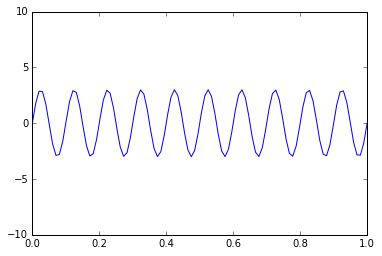

In [8]:
pltsin(10, 3)

#### Changing arguments

Now, if you want to see how the arguments affect the result you would need to rerun the cell above over and over again. Luckily, the ipywidgets make it more fun.

In [9]:
from ipywidgets import interact

Just pass the function name into `interact()` as a first argument. Then add its arguments and their respective range (start, stop, step):

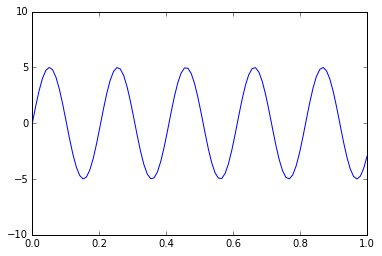

In [10]:
_ = interact(pltsin, freq=(1,10,0.1), ampl=(1,10,1))

And voila, you can change frequency and amplitude interactively using the two independent sliders.

#### Another example

Of course, `interact()` can be used not only for plotting. For example, using code from [this](http://stackoverflow.com/questions/2068372/fastest-way-to-list-all-primes-below-n/3035188#3035188) StackOverflow answer, we can print out a sequence of prime numbers smaller than a given number n.

In [11]:
def primesfrom3to(n):
    """ Returns a array of primes, 3 <= p < n """
    sieve = np.ones(n//2, dtype=np.bool)
    for i in range(3,int(n**0.5)+1,2):
        if sieve[i//2]:
            sieve[i*i//2::i] = False
    res = 2*np.nonzero(sieve)[0][1::]+1
    seq = ''
    for i in res:
        seq += ' {}'.format(i)
    return seq[1:]

And then make the function interactive:

In [12]:
_ = interact(primesfrom3to, n=(3,100,1)) # _ used to suppress output

'3 5 7 11 13 17 19 23 29 31 37 41 43 47'

## ipywidgets + contourf + real data

How can we apply `interact()` to real data analysis in Earth sciences? Well, one of the trivial application is to explore N-dimensional fields stored NetCDF files.

In [13]:
import netCDF4 as nc

As a sample data file we will use the same `data.nc` file from previous examples.

In [14]:
fpath = '../data/data.nc'

Here we create a function `ncfun()`, whose arguments are:

* NetCDF file name
* name of one of the variables stored in that file
* assuming we have 4d-arrays, time and level indices (`=0` by default).

In a nutshell, the function opens a file using netCDF4 module, reads the variable labelled `varname`, as well as longitude and latitude arrays, and then displays lon-lat horizontal cross-section.

In [15]:
def ncfun(filename, varname='', time=0, lev=0):
    with nc.Dataset(filename) as da:
        arr = da.variables[varname][:]
        lon = da.variables['longitude'][:]
        lat = da.variables['latitude'][:]

    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    c = ax.contourf(lon, lat, arr[time, lev, ...], cmap='viridis')
    fig.colorbar(c, ax=ax, shrink=0.5)

This function is easily wrapped by `interact()`:

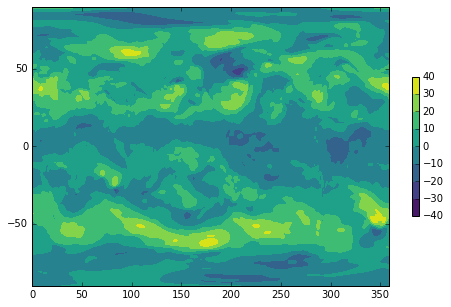

In [16]:
_ = interact(ncfun, filename=fpath, 
                    varname=['u','v'], 
                    time=(0,1,1), lev=(0,3,1))

## ncview clone in Jupyter

**Tools: iris, cartopy, ipywidgets**

We can improve that function and effectively create a clone of the [ncview](http://meteora.ucsd.edu/~pierce/ncview_home_page.html) or [Panoply](http://www.giss.nasa.gov/tools/panoply/). We also will use the capabilities of iris and cartopy packages.

In [17]:
import iris
import cartopy.crs as ccrs

In [18]:
iris.FUTURE.netcdf_promote = True # see explanation in previous posts

For colour schemes we will use palettable package (brewer2mpl successor). It is available on PyPi (`pip install palettable`).

In [19]:
import palettable

In [20]:
def plot_cube(cube, time=0, lev=0, cmap='viridis'):
    """Display a cross-section of iris.cube.Cube on a map"""
    # Get cube data and extract a 2d lon-lat slice
    arr = cube.data[time, lev, ...]
    # Find longitudes and latitudes
    lon = cube.coords(axis='x')[0].points
    lat = cube.coords(axis='y')[0].points
    
    # Create a figure with the size 8x5 inches
    fig = plt.figure(figsize=(8,5))
    # Create a geo-references Axes inside the figure
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
    # Plot coastlines
    ax.coastlines()
    # Plot the data as filled contour map
    c = ax.contourf(lon, lat, arr, cmap=cmap)
    # Attach a colorbar shrinked by 50%
    fig.colorbar(c, ax=ax, shrink=0.5)

The interesting part is below. We use another function that have only one argument - a file name. It opens the file and then allows us to choose a variable to plot (in the previous example we had to know variable names prior to executing the function).

In [21]:
def iris_view(filename):
    """Interactively display NetCDF data"""
    # Load file as iris.cube.CubeList
    cubelist = iris.load(filename)
    # Create a dict of variable names and iris cubes
    vardict = {i.name(): cubelist.extract(i.name())[0] for i in cubelist}
    # Use sequential colorbrewer palettes for colormap keyword
    cmaps = [i for i in palettable.colorbrewer.COLOR_MAPS['Sequential']]
    
    interact(plot_cube, 
             cube=vardict,
             time=(0,1,1),
             lev=(0,3,1),
             cmap=cmaps)

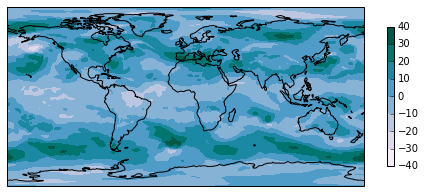

In [22]:
iris_view(fpath)

This is by no means a finished ncview-killer app. If you played with it, you could have noticed that it's much slower than ncview, even though the NetCDF file size is a little less than 10 Mb. However, you are free to customize this function in any possible way and use the power of Python and Jupyter.

We can keep tweaking the code above forever: we can make it more generic, we can add a second subplot, we can substitute time and level indices by their actual values, we can update colormap depending on data range and so on. By the way, any comments, suggestions and PRs are very welcome.

Final remarks. The interactive data visualisation is a very hot topic, and beside 'out-of-the-box' ipywidgets there are several Python packages that make use of JavaScript to allow you to build animations and interactive figures in Python. At some point we will talk about such projects as

* [bokeh](http://bokeh.pydata.org/en/latest/)

* [mpl3d](http://mpld3.github.io/)

* [holoviews](http://holoviews.org/)

* [plotly](https://plot.ly/)

In [23]:
HTML(html)